In [35]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

np.random.seed(10)

### CNN

In [36]:
# Convolution 2D class using Numpy
class Con2D():
    def __init__(self, kernel_size, stride, learning_rate):
        self.kernel_size = kernel_size
        self.stride = stride
        self.learning_rate = learning_rate

        self.kernel = np.random.randn(self.kernel_size, self.kernel_size) * np.sqrt(2.0 / (kernel_size * kernel_size))
        # print(self.kernel)
        
    def forward(self, image):
        self.image = image.copy()
        in_l, in_w = image.shape
        
        convolved_l = int((in_l - self.kernel_size) / self.stride) + 1
        convolved_w = int((in_w - self.kernel_size) / self.stride) + 1
        output = np.zeros((convolved_l, convolved_w))

        for l in range(convolved_l):
            for w in range(convolved_w):
                l_pos = l * self.stride
                w_pos = w * self.stride
                sub_img = image[l_pos : l_pos + self.kernel_size, w_pos : w_pos + self.kernel_size]
                output[l, w] = np.sum(sub_img * self.kernel)

        return output
    
    def backward(self, dout):
        self.dkernel = np.zeros_like(self.kernel)

        for l in range(0, dout.shape[0]):
            for w in range(0, dout.shape[1]):
                l_pos = l * self.stride
                w_pos = w * self.stride
                sub_img = self.image[l_pos : l_pos + self.kernel_size, w_pos : w_pos + self.kernel_size]
                self.dkernel += dout[l, w] * sub_img
        # self.dkernel /= self.dkernel.size

        self.dkernel = np.clip(self.dkernel, -1e3, 1e3)
        self.kernel -= self.learning_rate * self.dkernel
        return self.dkernel
        

In [37]:
# Activation - ReLU
class ReLU():
    def __init__(self):
        pass
    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output

    def backward(self, dout):
        # print(self.input > 0)
        self.doutput = dout * (self.input > 0)
        return self.doutput

# Activation - Sigmoid
class Sigmoid():
    def __init__(self):
        pass
    def forward(self, input):
        self.sig = 1 / (1 + np.exp(-input))
        return self.sig
    
    def backward(self, dout):
        return dout * self.sig * (1 - self.sig)  
    
# Activation - Softmax
class Softmax():
    def __init__(self):
        self.eps = 1e-6
    def forward(self, input):
        # Handle numerical stability
        self.input = input.copy()
        # Shift values to avoid overflow
        shifted_input = input - np.max(input)
        exp_values = np.exp(shifted_input)
        self.out = exp_values / (np.sum(exp_values) + self.eps)
        # Clip outputs to avoid zeros
        self.out = np.clip(self.out, self.eps, 1.0 - self.eps)
        return self.out

    def backward(self, dout):
        dx = self.out * (dout - np.sum(dout * self.out))
        return dx


In [38]:
# Pooling
class MaxPooling():
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
    
    def forward(self, input):
        self.input = input
        self.in_l, self.in_w, = input.shape
        
        convolved_l = int((self.in_l - self.pool_size) / self.stride) + 1
        convolved_w = int((self.in_w - self.pool_size) / self.stride) + 1
        
        self.output = np.zeros((convolved_l, convolved_w))
        self.mask = np.zeros_like(input)

        for l in range(convolved_l):
            for w in range(convolved_w):
                l_pos = l * self.stride
                w_pos = w * self.stride
                sub_img = self.input[l_pos : l_pos + self.pool_size, w_pos : w_pos + self.pool_size]
                # print(sub_img, np.max(sub_img), (np.unravel_index(np.argmax(sub_img), sub_img.shape))[0] + l, (np.unravel_index(np.argmax(sub_img), sub_img.shape))[1] + w) # np.where(sub_img == np.max(sub_img)))
                max_idx = np.unravel_index(np.argmax(sub_img), sub_img.shape)
                self.output[l, w] = np.max(sub_img)
                self.mask[l_pos + max_idx[0], w_pos + max_idx[1]] = 1

        return self.output

    def backward(self, dl):
        dout = np.zeros_like(self.input)
        # print(dl)
        dl_l, dl_w = dl.shape
        for l in range(dl_l):
            for w in range(dl_w):
                l_pos = l * self.stride
                w_pos = w * self.stride
                sub_img = self.mask[l_pos : l_pos + self.pool_size, w_pos : w_pos + self.pool_size]
                dout[l_pos : l_pos + self.pool_size, w_pos : w_pos + self.pool_size] += dl[l, w] * sub_img

        return dout


In [39]:
# Class for flattenting
class Flatten():
    def __init__(self) -> None:
        pass

    def forward(self, input):
        self.input = input
        self.in_l, self.in_w = self.input.shape
        return input.flatten()

    def backward(self, dloss):
        return dloss.reshape(self.input.shape)
    

In [40]:
# Feed Forward Network
class FeedForwardNetwork():
    def __init__(self, input_size, output_size, learning_rate):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Xavier initialization
        limit = np.sqrt(2.0/ (self.input_size + self.output_size))
        self.w = np.random.uniform(-limit, limit, (self.output_size, self.input_size))
        self.b = np.zeros((1, self.output_size))
        # print(self.w)

    def forward(self, input):
        # print(input.shape, self.w.shape)
        if len(input.shape) == 1:
            self.input = input.reshape(1, -1) # add a 1 to the dimension
        else:
            self.input = input
        self.h = np.dot(self.input, self.w.T) + self.b
        return self.h
    
    def backward(self, dloss):
        dw = np.dot(dloss.T, self.input) 
        db = np.sum(dloss, axis = 0, keepdims = True)

        self.w -= self.learning_rate * dw
        self.b -= self.learning_rate * db

        dinput = np.dot(dloss, self.w)
        return dinput


### Classifying MNIST Dataset

In [55]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize inputs
x_train, x_test = x_train / 255, x_test / 255

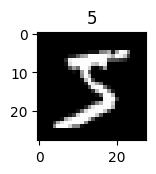

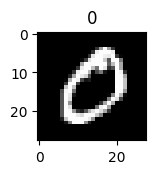

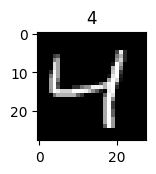

In [56]:
for i in range(3):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])
    plt.show()

In [57]:
# Understanding size conversion
kernel_size = 5
pool_size = 3
stride = 1
c_s = ((28 - kernel_size) / stride) + 1

p_s = ((c_s - pool_size) /stride) + 1
print("Size after Convolution:", c_s, "\nSize after Pooling:", p_s)

Size after Convolution: 24.0 
Size after Pooling: 22.0


In [58]:
# Expansion function for targets
def expansion(target):
    one_hot = np.zeros(10)
    one_hot[target] = 1
    return one_hot

# Multi class cross entropy
def multi_class_cross_entropy(target, y_pred):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = - np.sum(target * np.log(y_pred), axis=0).mean()
    return loss

In [63]:
# Training loop

# Learning Rate
alpha = 0.0001

epochs = 10

# CNN hyperparameters
kernel_size = 5
pool_size = 3
stride = 1

# Feed Forward Network hyperparameters
input_size = 484
output_size = 10

# Initialization of modules
conv_layer1 = Con2D(kernel_size, stride, alpha)
conv_act1 = ReLU()
pool1 = MaxPooling(pool_size, stride)

flatten = Flatten()
ffn1 = FeedForwardNetwork(input_size, output_size, alpha)  # First feedforward network
sof_act = Softmax()

avg_loss = []
epoch_losses = []

for epoch in range(epochs):

    num_samples = 0

    for idx in tqdm(np.random.choice(len(x_train), 3000)):
        # Forward pass
        num_samples += 1
        x = x_train[idx]
        target = expansion(y_train[idx])
        # print(target, y_train[idx])

        # First CNN block
        convolved_img1 = conv_layer1.forward(x)
        conv_relu1 = conv_act1.forward(convolved_img1)
        conv_pool1 = pool1.forward(conv_relu1)

        # Flatten and feed forward
        flat = flatten.forward(conv_pool1)
        layer1 = ffn1.forward(flat)
        layer1_sof = sof_act.forward(layer1)

        # Compute loss
        loss = multi_class_cross_entropy(target, layer1_sof)
        epoch_losses.append(loss)  # Collect loss for this iteration

        # Backpropagation
        dloss = (layer1_sof - target)  # / target.size
        # print(dloss)

        dffn1 = ffn1.backward(dloss)
        dflat = flatten.backward(dffn1)

        dpool1 = pool1.backward(dflat)
        dactivated1 = conv_act1.backward(dpool1)
        dkernel1 = conv_layer1.backward(dactivated1)

    avg_loss.append(np.mean(epoch_losses))  # Compute average loss for the epoch
    print("Loss: ", avg_loss[epoch])


100%|██████████| 3000/3000 [00:14<00:00, 206.81it/s]


Loss:  0.17507528795161761


100%|██████████| 3000/3000 [00:14<00:00, 207.27it/s]


Loss:  0.1329847202051662


100%|██████████| 3000/3000 [00:14<00:00, 207.75it/s]


Loss:  0.11078817250651996


100%|██████████| 3000/3000 [00:14<00:00, 207.60it/s]


Loss:  0.09733102389797102


100%|██████████| 3000/3000 [00:14<00:00, 207.35it/s]


Loss:  0.08708857232496633


100%|██████████| 3000/3000 [00:14<00:00, 207.59it/s]


Loss:  0.08035889291537576


100%|██████████| 3000/3000 [00:14<00:00, 208.03it/s]


Loss:  0.07501435264256054


100%|██████████| 3000/3000 [00:14<00:00, 207.29it/s]


Loss:  0.07115909396761269


100%|██████████| 3000/3000 [00:14<00:00, 206.77it/s]


Loss:  0.06833312822462485


100%|██████████| 3000/3000 [00:14<00:00, 207.21it/s]

Loss:  0.06566168555612158


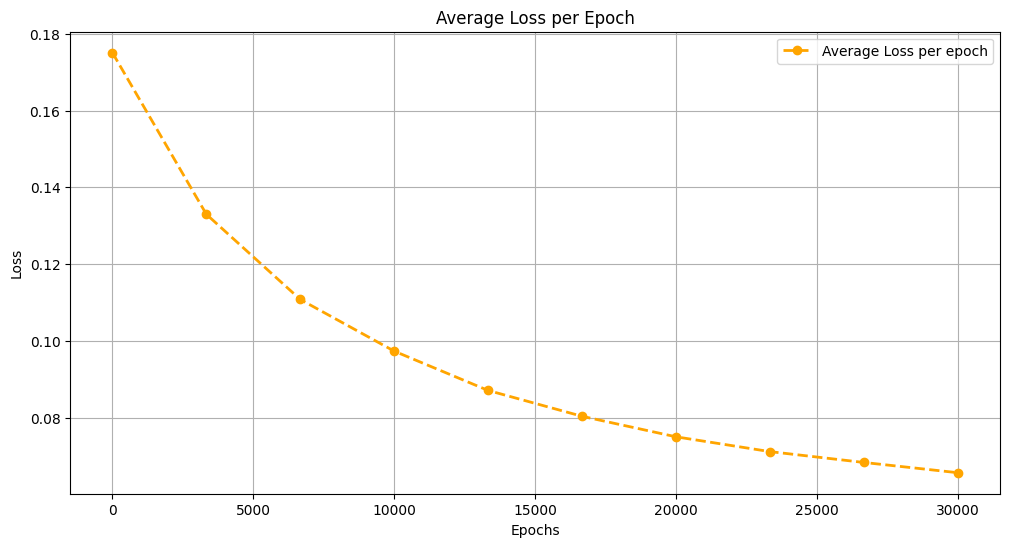

In [65]:
# Loss plot
# Create x-axis for avg_loss (epochs)
epochs = np.linspace(1, len(epoch_losses), len(avg_loss))

# Plot avg_loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, avg_loss, label="Average Loss per epoch", color="orange", marker='o', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Loss per Epoch")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [66]:
# Validation loop

count = 0
for idx, _x in enumerate(tqdm(x_test[:1000])):
    convolved_img = conv_layer1.forward(_x)
    # print("Convolved Shape:", convolved_img.shape) #"convolved_i1mg:", convolved_img)

    conv_relu = conv_act1.forward(convolved_img)
    # print("Relu Shape:", conv_relu.shape) # "conv_relu:", conv_relu,)

    conv_pool = pool1.forward(conv_relu)
    # print("Pooling Shape:", conv_pool.shape) # "conv_pool:", conv_pool,)

    flat = flatten.forward(conv_pool)
    # print("Flatten Shape:", flat.shape) # "flat:", flat,)

    layer1 = ffn1.forward(flat)

    # print("layer1 Shape: ", layer1.shape)
    layer1_sof = sof_act.forward(layer1)

    if np.argmax(layer1_sof) == y_test[idx]:
        count += 1
        #print(idx, layer1_sig, y_test[idx])

accuracy = (count / 1000) * 100
print("Accuracy: ", accuracy)

100%|██████████| 1000/1000 [00:03<00:00, 322.41it/s]

Accuracy:  85.5


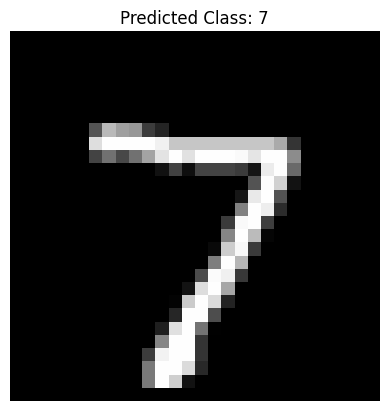

True Label: 7
Predicted Class: 7


In [67]:
# Forward pass on a single test image and plot the image
import matplotlib.pyplot as plt

idx = 0

# Select a single test image
test_image = x_test[idx]

# Perform forward pass
convolved_img = conv_layer1.forward(test_image)
conv_relu = conv_act1.forward(convolved_img)
conv_pool = pool1.forward(conv_relu)
flat = flatten.forward(conv_pool)
layer1 = ffn1.forward(flat)
layer1_sof = sof_act.forward(layer1)

# Get the predicted class
predicted_class = np.argmax(layer1_sof)

# Plot the input image
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

# Output the true label and predicted class
print("True Label:", y_test[idx])
print("Predicted Class:", predicted_class)

### Tensorflow Model

In [49]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [50]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

model = models.Sequential()
model.add(layers.Conv2D(24, (5, 5), activation='relu', input_shape= (28, 28, 1)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(10))
model.add(layers.Softmax())

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        15,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,994 (62.48 KB)

 Trainable params: 15,994 (62.48 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=4, validation_data=(x_test, y_test))

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6899 - loss: 1.1103 - val_accuracy: 0.9301 - val_loss: 0.2531
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9266 - loss: 0.2550 - val_accuracy: 0.9459 - val_loss: 0.1864
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9471 - loss: 0.1866 - val_accuracy: 0.9585 - val_loss: 0.1441
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1473 - val_accuracy: 0.9657 - val_loss: 0.1208


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted output: [[1.3159849e-06 3.7020209e-09 6.0372781e-06 9.1286980e-05 2.4745978e-08
  2.2658910e-06 1.3711339e-10 9.9979001e-01 5.4809152e-07 1.0852865e-04]], Predicted class: 7


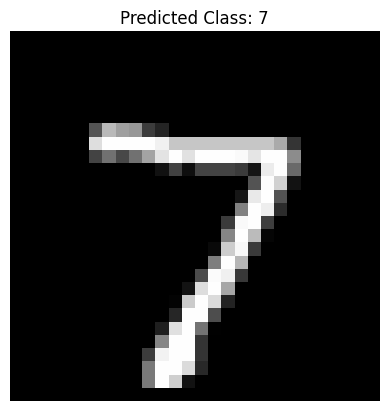

In [52]:
# Reshape a single test sample for prediction
sample_input = x_test[0].reshape(1, 28, 28, 1)
predicted_output = model.predict(sample_input)

# Get the class with the highest probability
predicted_class = predicted_output.argmax()
print(f"Predicted output: {predicted_output}, Predicted class: {predicted_class}")

# Plot the image
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()
